# Descente de gradient et variante en Python

On considère une fonction $f:\mathbb{R}^d \mapsto \mathbb{R}$ différentiable et le problème (que l'on suppose bien défini) :
$$x^* = \arg\min_{x\in \mathbb{R}^d} f(x)$$


## Descente de gradient classique


Pour le résoudre, on se propose le schéma de la descente de gradient définit par une séquence $(x_t)_{t\in \mathbb{N}}$ avec $x_0 \in \mathbb{R}$ et :
$$x_{t+1} = x_t - \eta \nabla f(x_t)$$

Le paramètre $\eta > 0$ est appelé le pas de descente ou *learning rate*.

### Questions
1. Ecrire une fonction qui renvoie la valeur $x^*$ pour une fonction donnée en un nombre d'itérations fixé.
2. Faire évoluer la fonction précédente pour qu'elle renvoie, à la demande, l'ensemble de la séquence $(x_t)_{t\in \mathbb{N}}$.
3. Faire évoluer la fonction précédente pour qu'elle s'arrête avant le nombre d'itérations fixé si la variation de la fonction $f$ entre deux valeurs de la séquence $(x_t)_{t\in \mathbb{N}}$ est inférieur à un seuil $\varepsilon$ à renseigner.
4. A partir de cette fonction, proposer une visualisation qui montre l'impact du choix de la valeur de $\eta$ sur un exemple choisi. Commenter.
5. On considère la fonction $f(x) = (x-1)(x-2)^2$. Visualiser la descente de gradient pour $x_0=-0.6$ et avec plusieurs learning rate. Commenter.

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='whitegrid')

In [2]:
def gradient_descent(f, df, x0, learning_rate=0.1, max_iteration=50, epsilon=1e-8, path=False):
    descent = [x0]
    last_value = x0

    
    for iteration in range(1, max_iteration+1):
        last_value = descent[iteration-1]
        
        update = learning_rate * df(last_value)
        descent.append(last_value - update)
        if np.abs(f(descent[iteration]) - f(last_value)) < epsilon:
            break
    
    
    return descent if path else descent[-1]

Nous choisissons un exemple très simple $f(x) = \frac{1}{2}(x-1)^2$ et nous allons faire varier les différents learning rate pour visualiser l'impact de cet hyper-paramètre.

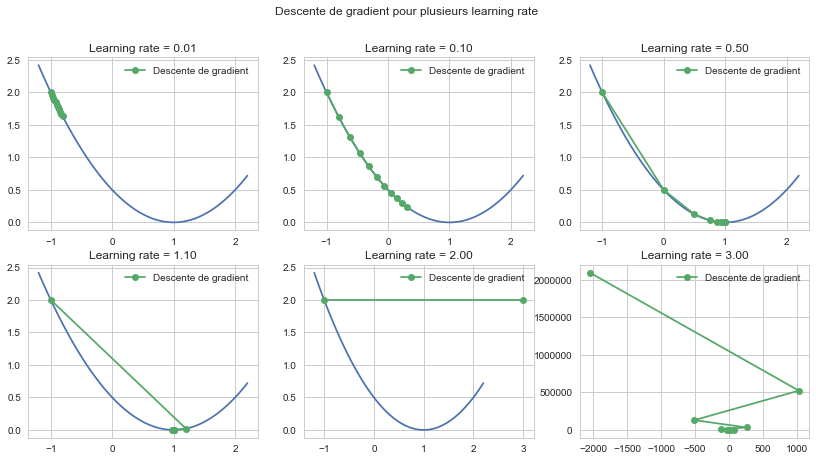

In [3]:
f = lambda x: 0.5 * ((x-1) ** 2)
df = lambda x: x - 1
x0 = -1
learning_rate = 0.05
x = np.linspace(-1.2, 2.2, 100)




plt.figure(figsize=(14, 7))
index = 1
for learning_rate in [0.01, 0.1, 0.5, 1.1, 2, 3]:
    x_descent = gradient_descent(f, df, x0, learning_rate=learning_rate, max_iteration=10, path=True)
    
    plt.subplot (2, 3, index)
    plt.plot(x, f(x))
    plt.plot(x_descent, f(np.array(x_descent)), 'o-', label="Descente de gradient")
    
    plt.legend()
    plt.title("Learning rate = %0.2f" % learning_rate)
    
    index += 1

plt.suptitle("Descente de gradient pour plusieurs learning rate")
plt.show()

Avec ces six exemples on comprend l'impact du learning rate :
- S'il est trop faible on descend trop doucement et donc il faudra un grand nombre d'itérations avant de converger
- S'il est trop fort on risque de ne pas converger : soit on oscille entre deux valeurs soit on diverge complétement

Ces remarques sont guidées essentiellement par la première et les deux dernières figures. Les trois figure restante nous permettent d'illuster les intuitions que l'on a sur la descente de gradient. Elle dépend bien de la pente : dans la deuxième figure le pas de descente ralenti. C'est également vrai dans le troisième tracé qui ralenti fortement à l'approche de la convergence.
Finalement, la quatrième figure montre que même si l'on peut *rater* le point de convergence, l'algorithme travaille en direction et s'adapte pour viser dans la bonne direction.



Il nous reste à essayer sur l'exemple de la question 5.

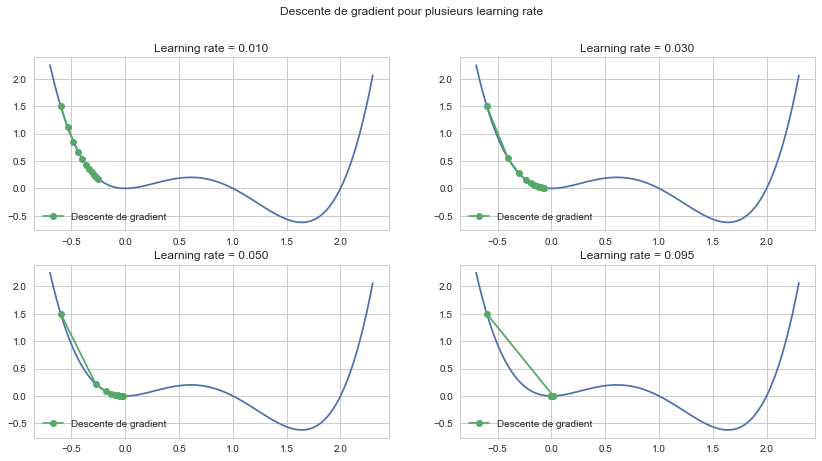

In [4]:
f = lambda x: (x-1) * (x-2) * (x**2)
df = lambda x: 4*(x**3) - 9*(x**2) + 4*x
x0 = -0.6
x = np.linspace(-0.7, 2.3, 100)

plt.figure(figsize=(14, 7))
index = 1
for learning_rate in [0.01, 0.03, 0.05, 0.095]:
    x_descent = gradient_descent(f, df, x0, learning_rate=learning_rate, max_iteration=10, path=True)
    
    plt.subplot (2, 2, index)
    plt.plot(x, f(x))
    plt.plot(x_descent, f(np.array(x_descent)), 'o-', label="Descente de gradient")
    
    plt.legend()
    plt.title("Learning rate = %0.3f" % learning_rate)
    
    index += 1

plt.suptitle("Descente de gradient pour plusieurs learning rate")
plt.show()

Au delà d'un learning rate de 0.1, on observe une divergence. Et on observe avec cet exemple que dans le cas d'une fonction qui n'est pas convexe, donc qui n'admet pas un unique minimum, alors le point de départ compte. Seulement, il est difficile de savoir à l'avance quel est un bon point départ. Pour essayer de résoudre ce problème, intéressons-nous à une variante.



## Descente de gradient avec momentum

On modifie le schéma de descente de gradient avec l'introduction d'un nouveau paramètre $\gamma > 0$ :
$$\displaystyle x_{t+1} = x_t - \left(\eta \nabla f(x_t) + \gamma (x_t - x_{t-1})\right)$$

La différence avec le schéma précédent est l'ajout d'une *mémoire* (très courte) qui permet de capitaliser sur la vitesse de convergence *locale*, et donc accélérer dans nous sommes dans une pente forte. L'ajout de momentum peut donc permettre d'accélérer largement une descente de gradient.

### Questions
6. Faire évoluer la fonction définie jusqu'ici pour intégrer le momentum. Permettre à l'utilisateur de conserver quand même la possibilité de ne pas avoir de momentum.
7. Proposer une visualisation qui permet d'apprécier les effets du momentum sur une descente de gradient
8. Reprendre l'exemple de la question 5 avec un learning rate de 0.05 et un momentum de 0.75. Commenter.

In [5]:
def gradient_descent(f, df, x0, learning_rate=0.1, momentum=0, max_iteration=50, epsilon=1e-8, path=False):
    descent = [x0]
    last_value = x0
    update = 0
    
    
    for iteration in range(1, max_iteration+1):
        last_value = descent[iteration-1]
        
        new_update = learning_rate * df(last_value) + momentum * update
        descent.append(last_value - new_update)
        if np.abs(f(descent[iteration]) - f(last_value)) < epsilon:
            break
            
        update = new_update
    
    
    return descent if path else descent[-1]

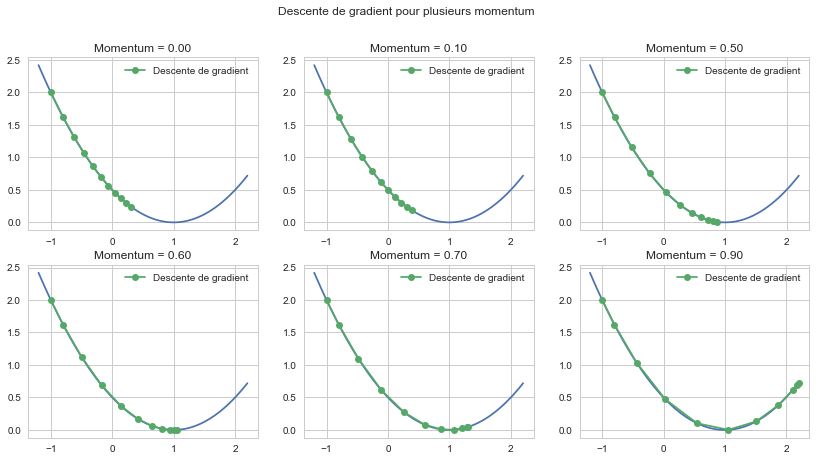

In [6]:
f = lambda x: 0.5 * ((x-1) ** 2)
df = lambda x: x - 1
x0 = -1
learning_rate = 0.1
x = np.linspace(-1.2, 2.2, 100)




plt.figure(figsize=(14, 7))
index = 1
for momentum in [0, 0.1, 0.5, 0.6, 0.7, 0.9]:
    x_descent = gradient_descent(f, df, x0, learning_rate=learning_rate, momentum=momentum, max_iteration=10, path=True)
    
    plt.subplot (2, 3, index)
    plt.plot(x, f(x))
    plt.plot(x_descent, f(np.array(x_descent)), 'o-', label="Descente de gradient")
    
    plt.legend()
    plt.title("Momentum = %0.2f" % momentum)
    
    index += 1

plt.suptitle("Descente de gradient pour plusieurs momentum")
plt.show()

Nous voyons que le momentum accélère bien la convergence comme attendu, et peut également donner lieu à des oscillations si l'on arrive *trop vite* vers le point de convergence. C'est un paramètre à exploiter plutôt avec des learning rate faible pour compenser la prise de vitesse graduelle. Voyons un exemple.

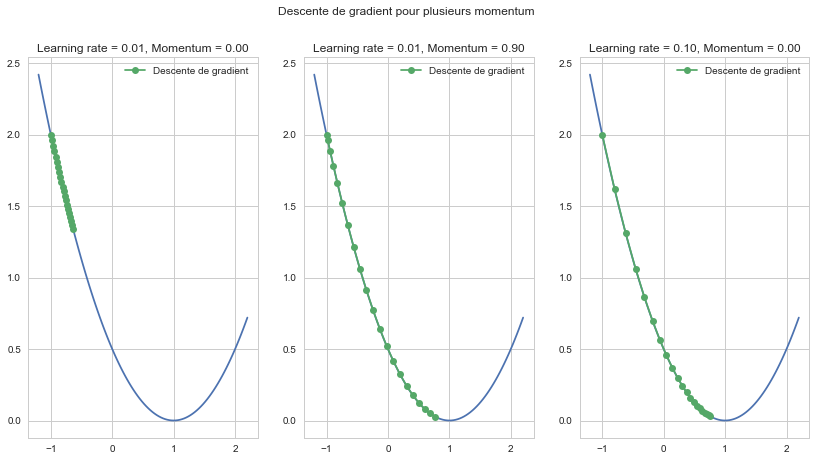

In [7]:
plt.figure(figsize=(14, 7))
index = 1
for learning_rate, momentum in zip([0.01, 0.01, 0.1], [0, 0.9, 0]):
    x_descent = gradient_descent(f, df, x0, learning_rate=learning_rate, momentum=momentum, max_iteration=20, path=True)
    
    plt.subplot (1, 3, index)
    plt.plot(x, f(x))
    plt.plot(x_descent, f(np.array(x_descent)), 'o-', label="Descente de gradient")
    
    plt.legend()
    plt.title("Learning rate = %0.2f, Momentum = %0.2f" % (learning_rate, momentum))
    
    index += 1

plt.suptitle("Descente de gradient pour plusieurs momentum")
plt.show()

Sur cet exemple, ajouter un momentum adapté nous a permit d'accélérer largement la convergence. Presque comme si nous avions multiplié par 10 le learning rate !

Reprenons l'exemple de la question 5 avec un minima local et un minima global :

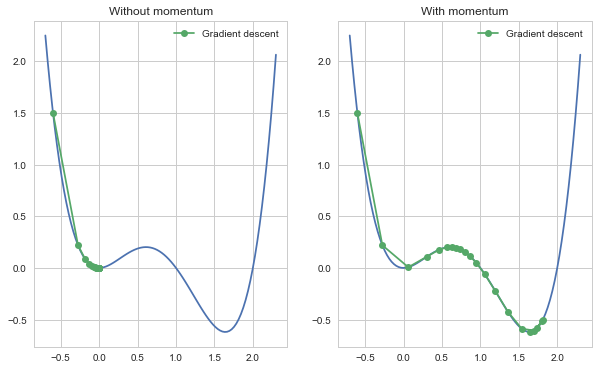

In [8]:
f = lambda x: (x-1)*(x-2)*(x**2)
df = lambda x: 4*x**3 - 9*x**2+4*x
x0 = -0.6
learning_rate = 0.05
x = np.linspace(-0.7, 2.3, 100)

x_momentum_0 = gradient_descent(f, df, x0, learning_rate=learning_rate, momentum=0, max_iteration=20, path=True)
x_momentum_1 = gradient_descent(f, df, x0, learning_rate=learning_rate, momentum=0.75, max_iteration=20, path=True)



plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(x, f(x))
plt.plot(x_momentum_0, [f(x) for x in x_momentum_0], 'o-', label="Gradient descent")
plt.legend()
plt.title("Without momentum")

plt.subplot(1, 2, 2)
plt.plot(x, f(x))
plt.plot(x_momentum_1, [f(x) for x in x_momentum_1], 'o-', label="Gradient descent")
plt.title("With momentum")
plt.legend()

plt.show()


Le momentum a eu ici pour effet de donner assez *d'énergie* à la descente pour passer le col que l'on observe et finalement *tomber* dans le minimum global.